In [1]:
"""
SEE: https://github.com/sudoswap/lssvm/blob/main/src/LSSVMPair.sol
Events to query for are:
  1. SwapNFTInPair()
    - emitted by LSSVMPair.swapNFTsForToken()  (sell order)
    - has no data so need to look at Transfer event for volume
  2. SwapNFTOutPair()
    - emitted by LSSVMPair.swapTokenForAnyNFTs() (buy order)
    - has no data so need to look at Transfer event for volume
  3. SpotPriceUpdate(uint128 newSpotPrice)
    - emitted by LSSVMPair on spot price changes: use to track price changes
"""
# switch to sudo-ape wd first for ape project to work properly
import os
from pathlib import Path

if Path(*Path(os.getcwd()).parts[-2:]) == Path('sudo-ape/notebook'):
    os.chdir('..')

In [3]:
import pandas as pd
import typing as tp

from ape import accounts, chain, Contract, networks, project

In [4]:
networks.parse_network_choice('ethereum:mainnet:alchemy').__enter__()

<alchemy chain_id=1>

In [5]:
current_block = chain.blocks[-1].number
current_block

15535461

In [6]:
start_block = 14645816  # pair factory deployment
start_block

14645816

In [7]:
sudo_router = Contract("0x2B2e8cDA09bBA9660dCA5cB6233787738Ad68329")
sudo_router

<LSSVMRouter 0x2B2e8cDA09bBA9660dCA5cB6233787738Ad68329>

In [8]:
sudo_factory = Contract("0xb16c1342E617A5B6E4b631EB114483FDB289c0A4")
sudo_factory

<LSSVMPairFactory 0xb16c1342E617A5B6E4b631EB114483FDB289c0A4>

In [9]:
sudo_factory.NewPair

NewPair(address poolAddress)

In [10]:
# use address of top xmons pool to check is pool thru factory
sudo_factory.isPair("0x5caf332dca4e6c9e69d52f320c21e74845353db0", 0)

True

In [11]:
sudo_pair_xmons = Contract("0x5caf332dca4e6c9e69d52f320c21e74845353db0")
sudo_pair_xmons

<LSSVMPair 0x5caF332DcA4e6C9E69d52F320c21e74845353db0>

In [12]:
# TRADE pool type
sudo_pair_xmons.poolType()

2

In [13]:
# utility functions to unfold event arguments into separate columns
def unfold_event_args(key: str, event_args: dict) -> tp.Any:
    return event_args[key]

def unfold(df: pd.DataFrame):
    for key in df.iloc[-1]['event_arguments'].keys():
        df[key] = df['event_arguments'].apply(lambda ev: unfold_event_args(key, ev))

In [14]:
%time query_pairs = sudo_factory.NewPair.query("*", start_block=start_block)
query_pairs

INFO: Cache database has not been initialized
CPU times: user 43.8 s, sys: 6.49 s, total: 50.3 s
Wall time: 4min 29s


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index
0,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x08142348E6BBf233002b81047bc...,0xba75dd0b017667074a1ed080571fee06b3cea5444f25...,14650748,0xf63250e045af2d83fca5535fe3738deffd3c6f17f93b...,15,9
1,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x518b7160990AD19dcfF0Ba028e2...,0x7e33fe2f08ee09a339b127c8658a892600637da3448d...,14652189,0x4b0de468eecdfea07b64168655f129d43d8e56f01f42...,41,37
2,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x351E40e39ae7D0d60Dc283485bC...,0x230624db7d760f3ad189bdebb431ef74b6cd899855d6...,14652199,0x572e74e542e87e141a2176725d7b216133bd0d13dcf5...,150,117
3,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x0636a6Bd07dDBEA28a3cc63353e...,0xff03f1a4956f878f1bd42a6dfa2ec18165822cde3d15...,14652223,0x877d4993fe635aaaea71fa3c8bb8c705d67f86559c3e...,142,108
4,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x866C5c02dC07EE37146c4874d70...,0x0c2b148a424bb8f25f32ca3ded2c87704cb73ab5b65b...,14662427,0x8f687e0ea159efeb37fd7e65ec00a008e6b96cc1b7ee...,171,149
...,...,...,...,...,...,...,...,...
30020,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xD0C6F88a03Af7C6c3d679e44189...,0x40be0ee4a7e43fd5986da6b5fc6d504033d517e113eb...,15535139,0x190b8605894f6c58ca7a31935c3c7b499c44ab3b4e61...,57,47
30021,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x74B08778dCCCF87B46c1E33Af34...,0xa815119468260ea03492ed5fef15294bf2fc113c9a3b...,15535163,0x23f1983f291f8455f8f462e36c3e94fd595f00559531...,514,369
30022,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x8719b72e81D2f29223Df19d5656...,0x83cf461fe925c31fc1c2d220bd7622ec72f631145051...,15535231,0x0bea3da98446b4a4e4b92c240843fed973747ac5fe1f...,168,121
30023,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xE873b3DA6D2b8563f3516ad88af...,0x0197acedebeb6ec0330bd51f207546f33af628fe0f8c...,15535426,0xe84c69727e4d8e8790782e4b2046f6fa96f127ea5608...,182,171


In [16]:
unfold(query_pairs)

In [17]:
# ~30k pools deployed already over last 4 months
query_pairs

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,poolAddress
0,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x08142348E6BBf233002b81047bc...,0xba75dd0b017667074a1ed080571fee06b3cea5444f25...,14650748,0xf63250e045af2d83fca5535fe3738deffd3c6f17f93b...,15,9,0x08142348E6BBf233002b81047bc2f27026af10A5
1,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x518b7160990AD19dcfF0Ba028e2...,0x7e33fe2f08ee09a339b127c8658a892600637da3448d...,14652189,0x4b0de468eecdfea07b64168655f129d43d8e56f01f42...,41,37,0x518b7160990AD19dcfF0Ba028e245fA616b44F5E
2,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x351E40e39ae7D0d60Dc283485bC...,0x230624db7d760f3ad189bdebb431ef74b6cd899855d6...,14652199,0x572e74e542e87e141a2176725d7b216133bd0d13dcf5...,150,117,0x351E40e39ae7D0d60Dc283485bC627891Ec1D00E
3,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x0636a6Bd07dDBEA28a3cc63353e...,0xff03f1a4956f878f1bd42a6dfa2ec18165822cde3d15...,14652223,0x877d4993fe635aaaea71fa3c8bb8c705d67f86559c3e...,142,108,0x0636a6Bd07dDBEA28a3cc63353ea725e8cE509e2
4,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x866C5c02dC07EE37146c4874d70...,0x0c2b148a424bb8f25f32ca3ded2c87704cb73ab5b65b...,14662427,0x8f687e0ea159efeb37fd7e65ec00a008e6b96cc1b7ee...,171,149,0x866C5c02dC07EE37146c4874d704D3603bF5D950
...,...,...,...,...,...,...,...,...,...
30020,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xD0C6F88a03Af7C6c3d679e44189...,0x40be0ee4a7e43fd5986da6b5fc6d504033d517e113eb...,15535139,0x190b8605894f6c58ca7a31935c3c7b499c44ab3b4e61...,57,47,0xD0C6F88a03Af7C6c3d679e44189927104717F71C
30021,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x74B08778dCCCF87B46c1E33Af34...,0xa815119468260ea03492ed5fef15294bf2fc113c9a3b...,15535163,0x23f1983f291f8455f8f462e36c3e94fd595f00559531...,514,369,0x74B08778dCCCF87B46c1E33Af34c5E6b039e03d8
30022,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x8719b72e81D2f29223Df19d5656...,0x83cf461fe925c31fc1c2d220bd7622ec72f631145051...,15535231,0x0bea3da98446b4a4e4b92c240843fed973747ac5fe1f...,168,121,0x8719b72e81D2f29223Df19d56565C159C1Efe4f9
30023,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0xE873b3DA6D2b8563f3516ad88af...,0x0197acedebeb6ec0330bd51f207546f33af628fe0f8c...,15535426,0xe84c69727e4d8e8790782e4b2046f6fa96f127ea5608...,182,171,0xE873b3DA6D2b8563f3516ad88af22C24049e8414


In [18]:
# NewPair events don't give the NFT collection address; only give the pair address
# query for those collection addresses so can focus on only one collection at a time for now
def get_pair_specifics(key: str, x: pd.Series, is_method: bool = True) -> tp.Any:
    addr = x['poolAddress']
    pair = project.LSSVMPair.at(addr)
    val = getattr(pair, key)() if is_method else getattr(pair, key)
    return val

In [27]:
num_chunks = 100
chunk_size = int(len(query_pairs) / num_chunks)
chunk_size

300

In [28]:
# get the pool types first to only focus on poolType=2 TRADE
query_pairs_pool_chunks = []

In [29]:
# chunk the specifics queries since alchemy not having fun
idx_chunk = 0

In [81]:
# repeat execution of this until get specifics on poolType to filter out poolType!=2 pools
if idx_chunk < num_chunks+1:
    %time query_pairs_pool_chunk = query_pairs[chunk_size*idx_chunk:chunk_size*(idx_chunk+1)].apply(lambda x: get_pair_specifics('poolType', x), axis=1)
    query_pairs_pool_chunks.append(query_pairs_pool_chunk)
    idx_chunk += 1

ERROR: Unable to fetch contract type at '0x2aBdd8bdd9628a44655F5EF3F48bd0D40908D2C1' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x7bDa08EDeDFda94290094FD2Ac53356B74B6Bb15' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x8ea2e7c476Ac64E587a082e7c90956D08de00019' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0xf73758e96babae2d77cb5aa7739115db0AD98f66' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x11a0aDABcF11EB0Cb427e0865eB8B0cE481a963d' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0xF823cd60f13f13af1e028527E136FABa9123b68C' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x16932DD4c25242AbE82a056aD6521eD87FF3C146' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x5E795C879F4E9b77f349EEAe06c515CAeBe4B26f' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x25DC0f281f9853a64696759DFfa5050E29F924Bb' from explorer.
'mainnet'
ERROR: Una

ERROR: Unable to fetch contract type at '0x43A5EfE93361AfCa6fF9c9897161048B7D9F579F' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x462B2BcEEa36EAb33213427068c0dd24e81393b7' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x3FBAeD1D7b48EA01A2a61bd0BB34f9D8e4DC9f91' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x733E01d9F7a215EdB2e68307E35C16aD25B31ABf' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x1a73eBdd46F67fF046267A5AAe17dEee77B5e0fa' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0xd5Ed8EF2acCA4690aBe22CD1dd7483C5f3082948' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x5C8Ac56af0E025eA82005158Ce2609bd0CF5D3eF' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0xD9578256D81bFfD0f48021a2eBb358A18B6AE4E1' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0xC1Bde66625C75b917aCbd0818721cC2fb7A04868' from explorer.
'mainnet'
ERROR: Una

ERROR: Unable to fetch contract type at '0xCc68AD37C705Ad978850F6EAfdD683a89e047D75' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x4aA2B4FFCB39ed9FFa7BC0E330f87a62A6CFd5F6' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x6a8c3940b5D6F928D40C7190a1b11093d76419e6' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0xF68C6Cb4f6063d1908229B653C6B3026d991DA78' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x579df6A1c45A41c4D8834243EF8ab6b07f3AE0BE' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x122D63c8b30E9FBBFbf5dFaB8E12D9dBCf34Def4' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x85ECDE5643A7ABCE415EE22ddF502fcef5Cc5E7C' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x223E23A47461D42fF8E8aCCD8DE4c0cE45a082eB' from explorer.
'mainnet'
ERROR: Unable to fetch contract type at '0x375BFF2Ad204390236a1bEb720ad5797b9400346' from explorer.
'mainnet'
ERROR: Una

In [91]:
idx_chunk

17

In [92]:
query_pairs_pool_chunks

[0      1
 1      1
 2      1
 3      1
 4      1
       ..
 295    1
 296    1
 297    1
 298    1
 299    2
 Length: 300, dtype: int64,
 300    1
 301    1
 302    1
 303    1
 304    2
       ..
 595    1
 596    1
 597    1
 598    0
 599    0
 Length: 300, dtype: int64,
 600    1
 601    1
 602    0
 603    0
 604    0
       ..
 895    1
 896    1
 897    1
 898    1
 899    2
 Length: 300, dtype: int64,
 900     1
 901     1
 902     2
 903     1
 904     2
        ..
 1195    1
 1196    1
 1197    1
 1198    2
 1199    1
 Length: 300, dtype: int64,
 1200    1
 1201    1
 1202    1
 1203    2
 1204    1
        ..
 1495    1
 1496    2
 1497    0
 1498    0
 1499    1
 Length: 300, dtype: int64,
 1500    2
 1501    1
 1502    1
 1503    0
 1504    2
        ..
 1795    1
 1796    1
 1797    1
 1798    1
 1799    1
 Length: 300, dtype: int64,
 1800    1
 1801    1
 1802    1
 1803    1
 1804    2
        ..
 2095    1
 2096    0
 2097    1
 2098    0
 2099    1
 Length: 300, dtyp

In [85]:
sudo_pair_xmons.SpotPriceUpdate

SpotPriceUpdate(uint128 newSpotPrice)

In [86]:
# get start block from query_pairs IF query can't handle when start_block < contract creation block (it can, woot)
%time query_prices_xmons = sudo_pair_xmons.SpotPriceUpdate.query('*', start_block=start_block)
query_prices_xmons

CPU times: user 30.4 s, sys: 4.67 s, total: 35.1 s
Wall time: 4min 13s


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index
0,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9077669902912621000},0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,15198846,0xd3b29ce639c43280c2a194b638e07a5e1541824210aa...,54,37
1,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,15199800,0x420f1997f04b486a8ed114b32337abb0f8722e82ef1f...,79,82
2,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14077669902912621000},0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...,15203036,0x0e89e72ff162aa1b1ec18cdad70825885d7c0884f425...,233,138
3,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0x414ea41198833a399a68c9b66456047bc6dd349330d7...,15208415,0x36dce9b484abf8db83699dabf5d63cbca4b9f68cc7e2...,120,56
4,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9077669902912621000},0x28758b8d0ad21047a93b75089e210e0ca85f652842ef...,15218330,0x10112e7b56853191c7e46d36f0cca7431be567982f5c...,73,59
...,...,...,...,...,...,...,...,...
61,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 17330097087378640000},0x2946f9b515e1b1144a2a2a7de75e111bdc1700485e16...,15460128,0xbe6bdd7ff1c6ead20430c3ca591031e3cab7165b492d...,79,52
62,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14830097087378640000},0xc5dd46e77a6a15f76f76b34bebc89c57a0a7436febb7...,15460372,0x46a34b7810110fe9171b49155170a0a8af02658675e5...,190,127
63,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 17330097087378640000},0x15592fc9f37ff3366ca8cec45612d9b4dc6eec6b76ac...,15462678,0xa641413250e702a7032da1803bd91a6a9095ab11e9ec...,58,37
64,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14830097087378640000},0xe920b32111dc1c0691333c4880b495a944560a181646...,15487756,0xc545a2b6d360c6653972c1b1a52b1d90d7f59bcb9246...,52,81


In [87]:
unfold(query_prices_xmons)

In [88]:
# convert spot price from units of wei to units of ETH
query_prices_xmons['newSpotPrice'] = query_prices_xmons['newSpotPrice'] / 1e18

In [89]:
# only 64 price updates for this pool over the last 44 days since deployed (not much)
query_prices_xmons

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,newSpotPrice
0,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9077669902912621000},0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,15198846,0xd3b29ce639c43280c2a194b638e07a5e1541824210aa...,54,37,9.07767
1,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,15199800,0x420f1997f04b486a8ed114b32337abb0f8722e82ef1f...,79,82,11.57767
2,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14077669902912621000},0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...,15203036,0x0e89e72ff162aa1b1ec18cdad70825885d7c0884f425...,233,138,14.07767
3,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0x414ea41198833a399a68c9b66456047bc6dd349330d7...,15208415,0x36dce9b484abf8db83699dabf5d63cbca4b9f68cc7e2...,120,56,11.57767
4,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9077669902912621000},0x28758b8d0ad21047a93b75089e210e0ca85f652842ef...,15218330,0x10112e7b56853191c7e46d36f0cca7431be567982f5c...,73,59,9.07767
...,...,...,...,...,...,...,...,...,...
61,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 17330097087378640000},0x2946f9b515e1b1144a2a2a7de75e111bdc1700485e16...,15460128,0xbe6bdd7ff1c6ead20430c3ca591031e3cab7165b492d...,79,52,17.330097
62,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14830097087378640000},0xc5dd46e77a6a15f76f76b34bebc89c57a0a7436febb7...,15460372,0x46a34b7810110fe9171b49155170a0a8af02658675e5...,190,127,14.830097
63,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 17330097087378640000},0x15592fc9f37ff3366ca8cec45612d9b4dc6eec6b76ac...,15462678,0xa641413250e702a7032da1803bd91a6a9095ab11e9ec...,58,37,17.330097
64,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14830097087378640000},0xe920b32111dc1c0691333c4880b495a944560a181646...,15487756,0xc545a2b6d360c6653972c1b1a52b1d90d7f59bcb9246...,52,81,14.830097


<AxesSubplot:xlabel='block_number', ylabel='newSpotPrice'>

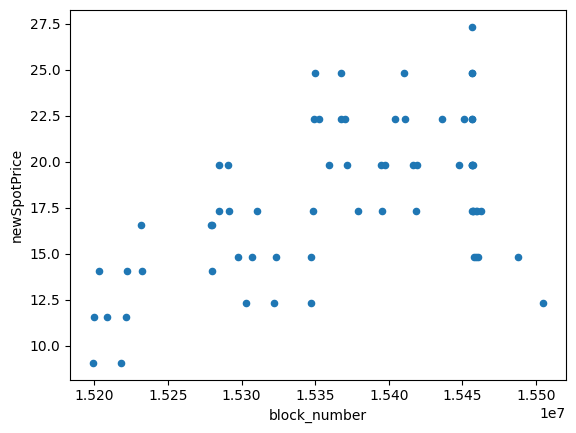

In [90]:
query_prices_xmons.plot(x='block_number', y='newSpotPrice', kind='scatter')